In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymysql
from sqlalchemy import create_engine
from wordcloud import WordCloud

In [2]:
engine = create_engine("mysql+pymysql://" + os.environ.get("mysql_user") + ":" + os.environ.get("mysql_key") + '@localhost:3306')

In [3]:
phi_pp_df_2 = pd.read_sql('select * from data_group_project.properties_public', con=engine)
phi_pp_df_2.head()

,index,Unnamed: 0,lng,building_code_description,category_code,category_code_description,central_air,depth,exempt_building,exempt_land,...,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,zip_code,lat,number_of_bedrooms
0,0,0,-75.147193,VACANT LAND RESIDE < ACRE,6,Vacant Land,None,42.00,0.0,0.0,...,0.0,None,None,None,None,None,0,191476133,39.930494,0.0
1,1,1,-75.147264,VACANT LAND RESIDE < ACRE,6,Vacant Land,None,38.66,0.0,0.0,...,0.0,None,None,None,None,None,0,191476133,39.930504,0.0
2,2,2,-75.147314,VACANT LAND RESIDE < ACRE,6,Vacant Land,None,38.66,0.0,0.0,...,0.0,None,None,None,None,None,0,191476133,39.930510,0.0
3,3,3,-75.146760,VACANT LAND RESIDE < ACRE,6,Vacant Land,None,50.00,0.0,39900.0,...,0.0,None,None,None,None,None,0,191476100,39.930285,0.0
4,4,4,-75.146813,VACANT LAND RESIDE < ACRE,6,Vacant Land,None,50.00,0.0,42600.0,...,0.0,None,None,None,None,None,0,191476100,39.930292,0.0


In [4]:
#Remove the unnamed column
phi_pp_df_2 = phi_pp_df_2.loc[:, ~ phi_pp_df_2.columns.str.contains('^Unnamed')]

In [5]:
phi_pp_df_2.shape

(581456, 44)

In [6]:
phi_pp_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581456 entries, 0 to 581455
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   index                      581456 non-null  int64  
 1   lng                        581344 non-null  float64
 2   building_code_description  581456 non-null  object 
 3   category_code              581456 non-null  int64  
 4   category_code_description  581456 non-null  object 
 5   central_air                285860 non-null  object 
 6   depth                      581454 non-null  float64
 7   exempt_building            580906 non-null  float64
 8   exempt_land                580906 non-null  float64
 9   exterior_condition         556191 non-null  float64
 10  fireplaces                 581435 non-null  float64
 11  frontage                   581454 non-null  float64
 12  fuel                       10900 non-null   object 
 13  garage_spaces              58

In [7]:
# The preliminary etl has been reduced the original columns from 79 to 45. The reasons for dropping because 
# for example, "the_geom" and "the_geom_webmercator" are intend for maps. For this notebook analtsis, the maps 
# dara will not be interactived

phi_pp_df_2.shape

(581456, 44)

In [8]:
phi_pp_df_2.market_value.isnull().any()

True

In [9]:
# Since this study is for housing price, we don't want to substitue NaN with mean data since we don't know the 
# detail information of the house. Here, we just removed them
phi_pp_df_2 = phi_pp_df_2.dropna(subset=['market_value'])

In [10]:
phi_pp_df_2.shape

(580906, 44)

In [11]:
# Now, all the house with market value
phi_pp_df_2.market_value.isnull().any()

False

In [12]:
# Also, drop those market_value price equal to 0 if any, it doesn't make sense
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.market_value == 0].index)

In [13]:
phi_pp_df_2.shape

(580286, 44)

Text(0.5, 0, 'Number of missing` data values')

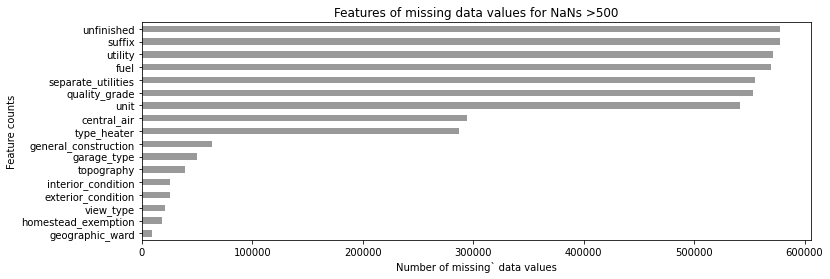

In [14]:
# For the other columns of data features, take a look at how many of them are missing
missing_data = phi_pp_df_2.isnull().sum()
missing_data = missing_data[missing_data > 500]
missing_data.sort_values(inplace=True)
missing_data.plot.barh(color='gray', alpha = 0.8, figsize=(12,4))
plt.title('Features of missing data values for NaNs >500')
plt.ylabel('Feature counts')
plt.xlabel('Number of missing` data values')
# The 'unfinished', 'suffix', 'utility' 'fuel' and separate_utilitites, are the top 5 missing value features.
# Later, we will look into these data see find meaningful substitutions

### House Types Data

In [15]:
# we will study each features in the data set
# When we see a house, we will consider the type of house, such as residental, commercial, industrial?
# Next, we will deep into the 'category_code of these propreties'

category_code_description_count = phi_pp_df_2['category_code_description'].value_counts(dropna=False)

In [16]:
category_code_description_count

Single Family    461199
Vacant Land       44127
Multi Family      42314
Mixed Use         14356
Commercial        13964
Industrial         4326
Name: category_code_description, dtype: int64

In [17]:
#Since the project focuses on residetnial house, we remove the 
# 'Vacant Land (6)', 'Commerical (4)' and 'Industrial (5)' data
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Vacant Land'].index)

In [18]:
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Commercial'].index)

In [19]:
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Industrial'].index)

In [20]:
category_code_count = phi_pp_df_2['category_code_description'].value_counts(dropna=False)

In [21]:
category_code_count
#Now, only 'Single Family', 'Multi Family', and 'Mixed Use' Category left

Single Family    461199
Multi Family      42314
Mixed Use         14356
Name: category_code_description, dtype: int64

In [22]:
# The dataset volumns reduce again
phi_pp_df_2.shape

(517869, 44)

Text(0.5, 1.0, 'market_value vs type of houses')

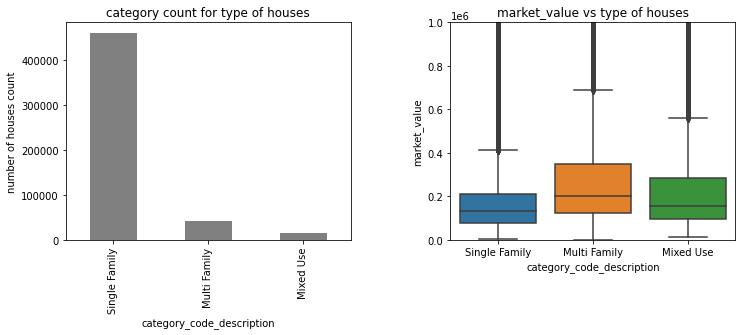

In [23]:
#Next, we will deep into these three catagories. Seaborn Plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), gridspec_kw={'wspace':0.35})

category_code_plots = phi_pp_df_2.category_code_description.value_counts()
category_code_plots.plot.bar(ax = ax1, color = 'gray')
ax1.set_title('category count for type of houses')
ax1.set_xlabel('category_code_description')
ax1.set_ylabel('number of houses count')


category_df = pd.concat([phi_pp_df_2['market_value'],
                       phi_pp_df_2['category_code_description']], axis = 1)
box_fig = sns.boxplot(x='category_code_description', y='market_value', data=category_df, ax=ax2)
box_fig.axis(ymin=0, ymax=1000000)
ax2.set_title('market_value vs type of houses')

In [24]:
# The boxplot result show that Multi Family has better average market value than Mixed Use family

### House Value with Geographic Data

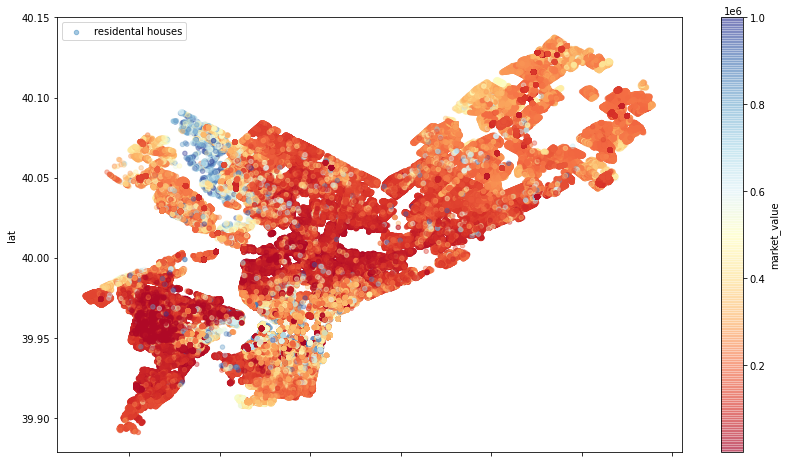

In [25]:
# Next, look at the geographic featurem since we have longitude and latitude data. 
# Herem we filter the value more than $1,000,000
geo_phi_pp_vis = phi_pp_df_2[phi_pp_df_2.market_value <= 1000000].plot(kind='scatter', x='lng', y='lat', 
                label='residental houses',c='market_value', cmap=plt.get_cmap('RdYlBu'), 
                colorbar=True, alpha=0.4, figsize=(14,8))
geo_phi_pp_vis.legend()

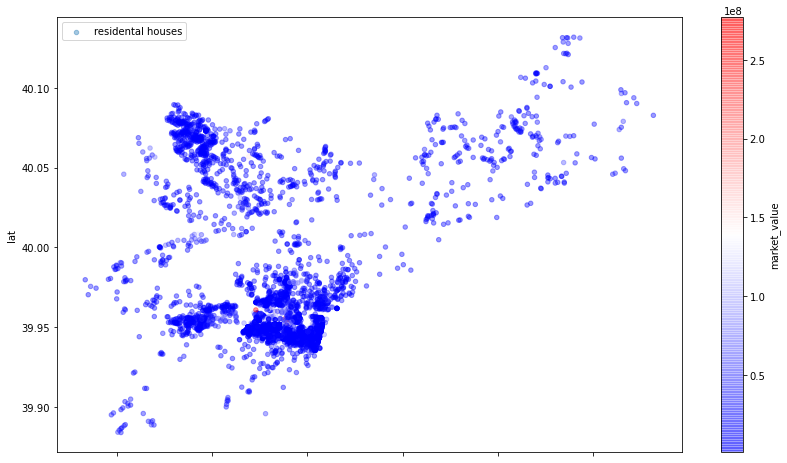

In [26]:
# Show the distribution of houses with market value greater than $1,000,000
geo_phi_pp_vis = phi_pp_df_2[phi_pp_df_2.market_value > 1000000].plot(kind='scatter', x='lng', y='lat',
                label='residental houses',c='market_value', cmap=plt.get_cmap('bwr'), 
                colorbar=True, alpha=0.4, figsize=(14,8))
geo_phi_pp_vis.legend()

#### Based on the geodata, the houses locate at Center Philly and the Northwest Phily has the higher market vaule.

In [27]:
# Next, look at the zipcode, some of the zipcode contains "-", and the data type for 'zip_code' is string
phi_pp_df_2.zip_code.value_counts().sum()

517869

In [28]:
phi_pp_df_2.zip_code.dtypes

dtype('O')

In [29]:
#Only keep the first five digit for the zipcode, Philadephia Zipcode range 19102 - 10154
phi_pp_df_2['zip_code'] = phi_pp_df_2['zip_code'].str[:5]

In [30]:
phi_pp_df_2['zip_code'].head()

6     19147
7     19147
8     19147
9     19147
10    19147
Name: zip_code, dtype: object

In [31]:
phi_pp_df_2.head()

,index,lng,building_code_description,category_code,category_code_description,central_air,depth,exempt_building,exempt_land,exterior_condition,...,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,zip_code,lat,number_of_bedrooms
6,6,-75.147208,ROW 3 STY MASONRY,1,Single Family,Y,40.0,0.0,0.0,3.0,...,1131.0,A,None,None,None,I,1920,19147,39.930328,4.0
7,7,-75.147254,ROW 3 STY MASONRY,1,Single Family,Y,40.0,45000.0,0.0,3.0,...,1235.0,H,None,None,None,I,1920,19147,39.930338,3.0
8,8,-75.147302,ROW 2 STY MASONRY,1,Single Family,N,40.0,125300.0,0.0,4.0,...,816.0,A,None,None,None,I,1920,19147,39.930343,1.0
9,9,-75.147349,ROW 2 STY MASONRY,1,Single Family,N,38.0,0.0,0.0,4.0,...,792.0,H,None,None,None,I,1920,19147,39.930346,2.0
10,10,-75.147396,ROW 2 STY MASONRY,1,Single Family,N,40.0,0.0,0.0,4.0,...,816.0,H,None,None,None,I,1920,19147,39.930352,2.0


In [32]:
phi_pp_df_2.describe().round(2)

,index,lng,category_code,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,...,off_street_open,quality_grade,sale_price,street_code,taxable_building,taxable_land,total_area,total_livable_area,lat,number_of_bedrooms
count,517869.00,517862.00,517869.00,517869.00,5.178690e+05,517869.00,517835.00,517868.00,5.178690e+05,517868.00,...,517867.00,25303.00,5.178690e+05,517869.00,5.178690e+05,517869.00,517869.00,517868.00,517862.00,517868.00
mean,286886.16,-75.14,1.14,85.27,4.818079e+04,1867.09,3.87,0.04,1.063200e+03,0.38,...,0.12,3.65,2.953371e+05,53959.40,1.265676e+05,43272.33,2168.01,1718.91,40.00,2.25
std,164397.41,0.07,0.42,1365.34,8.322816e+05,128339.71,0.74,0.25,6.141487e+05,0.83,...,1.04,0.72,1.153651e+07,24530.81,8.950363e+05,251204.41,11297.21,8596.72,0.05,1.60
min,6.00,-75.27,1.00,0.00,0.000000e+00,0.00,0.00,0.00,0.000000e+00,0.00,...,0.00,0.00,0.000000e+00,11020.00,0.000000e+00,0.00,0.00,0.00,39.88,0.00
25%,145546.00,-75.18,1.00,58.00,0.000000e+00,0.00,4.00,0.00,1.500000e+01,0.00,...,0.00,3.00,1.000000e+00,32120.00,3.918500e+04,12420.00,895.80,1080.00,39.96,0.00
50%,290580.00,-75.15,1.00,77.15,2.000000e+04,0.00,4.00,0.00,1.600000e+01,0.00,...,0.00,4.00,4.750000e+04,54640.00,8.072000e+04,22779.00,1280.00,1260.00,40.00,3.00
75%,424858.00,-75.10,1.00,100.00,4.500000e+04,0.00,4.00,0.00,2.000000e+01,1.00,...,0.00,4.00,1.400000e+05,76580.00,1.358550e+05,46101.00,1993.16,1592.00,40.04,3.00
max,581455.00,-74.96,3.00,544500.00,1.712097e+08,69930716.00,7.00,5.00,4.320260e+08,95.00,...,99.00,6.00,9.487291e+08,89750.00,2.492028e+08,50914340.00,5248824.00,2445358.00,40.14,93.00


In [104]:
phi_pp_df_2.shape

(517869, 44)

In [33]:
# save one copy of dataframe here for Sparks SQL operation at Databicks to join tables with other datasets
phi_pp_df_2.to_csv('../data/phi_pp_df_3.csv')

In [105]:
# Clean some extreme value, market value small less than 20000 and value more than 5000000 will be removed
phi_pp_df_2 = phi_pp_df_2[(phi_pp_df_2['market_value']>20000)&(phi_pp_df_2['market_value']<5000000)]

In [106]:
phi_pp_df_2.shape

(511023, 44)

In [107]:
#Random Sample if need it (by fraction)
fraction_of_row_pp_df_2 = phi_pp_df_2.sample(frac=0.3, random_state = 2)

In [108]:
fraction_of_row_pp_df_2.shape

(153307, 44)

In [109]:
# change date type of zip_code from 'obecjt' to 'int64'
# fraction_of_row_pp_df_2.astype({'zip_code': 'int64'}).dtypes

In [110]:
fraction_of_row_pp_df_2.head()

,index,lng,building_code_description,category_code,category_code_description,central_air,depth,exempt_building,exempt_land,exterior_condition,...,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,zip_code,lat,number_of_bedrooms
364076,364076,-75.139717,SEMI/DET 2 STY MASONRY,1,Single Family,None,84.00,45000.0,0.0,5.0,...,1700.0,H,None,None,None,I,1943,19141,40.031995,4.0
100526,100526,-75.148279,ROW B/GAR 2 STY MASONRY,1,Single Family,N,90.00,45000.0,0.0,4.0,...,2015.0,A,None,None,None,I,1925,19126,40.054030,3.0
438908,438908,-75.025570,S/D W/B GAR 1 STY MASONRY,1,Single Family,None,100.00,45000.0,0.0,4.0,...,1201.0,None,None,None,None,I,1964,19115,40.090200,0.0
132877,132877,-75.227906,S/D W/B GAR 2 STY MASONRY,1,Single Family,Y,115.09,0.0,0.0,4.0,...,1472.0,H,None,None,None,I,1964,19128,40.049272,3.0
352099,352099,-75.222141,ROW 3.5 STY MASONRY,1,Single Family,None,110.00,45000.0,0.0,4.0,...,2888.0,None,None,None,None,I,1925,19143,39.948582,0.0


In [113]:
#Select on the market_value and zip_code column
zip_code_fraction_of_row_pp_df = pd.concat([fraction_of_row_pp_df_2['zip_code'],fraction_of_row_pp_df_2['market_value']], axis=1 )

In [114]:
zip_code_fraction_of_row_pp_df.head(100)

,zip_code,market_value
364076,19141,62900.0
100526,19126,121600.0
438908,19115,212400.0
132877,19128,229400.0
352099,19143,279000.0
...,...,...
157709,19134,49200.0
151497,19134,190100.0
380467,19143,49700.0
130366,19119,71000.0


In [115]:
zip_code_groupby = zip_code_fraction_of_row_pp_df.groupby('zip_code') #.filter(lambda x:len(x) >10)

In [116]:
#Now can look for the mean price of each zipcode
zip_code_groupby.describe()

market_value                                                     \
                count          mean            std        min        25%   
zip_code                                                                   
19102           547.0  5.255241e+05  486988.320184    27000.0   258900.0   
19103          2079.0  6.882518e+05  618440.457074    23600.0   294000.0   
19104          2522.0  2.616305e+05  396290.616183    20500.0    62525.0   
19106          1721.0  5.277811e+05  495807.942114    29000.0   261600.0   
19107          1119.0  4.238368e+05  443554.896158    29000.0   154100.0   
19110             1.0  2.438400e+06            NaN  2438400.0  2438400.0   
19111          5688.0  1.919488e+05  146776.495912    20800.0   141700.0   
19114          2909.0  2.046982e+05   61567.462580    35000.0   183700.0   
19115          3018.0  2.449978e+05  149942.836833    60400.0   197000.0   
19116          2971.0  2.440693e+05   76683.616485    40000.0   214950.0   
19118           830.0  6.099796e+05  414406.525124    25900.0   353075.0   
19119          2763.0  2.623798e+05  240494.433177    25900.0   136400.0   
19120          6240.0  9.613287e+04   45733.975590    20100.0    75575.0   
19121          3326.0  1.661311e+05  240391.393539    20100.0    45600.0   
19122          1622.0  2.122060e+05  233339.123228    20800.0   115900.0   
19123          1609.0  4.282048e+05  338890.392311    25000.0   267300.0   
19124          6218.0  1.005352e+05   91167.810538    20800.0    75100.0   
19125          3172.0  2.481951e+05  163805.489362    22900.0   160300.0   
19126          1441.0  1.608999e+05  142335.291946    22200.0   116400.0   
19127           863.0  2.727710e+05  239074.109499    24900.0   202850.0   
19128          3881.0  2.562837e+05  166963.092942    23000.0   203300.0   
19129          1160.0  2.264430e+05  240600.552478    21000.0   144900.0   
19130          2951.0  3.999155e+05  283889.739658    23600.0   239500.0   
19131          4001.0  1.045665e+05  114747.704674    20300.0    59100.0   
19132          4243.0  4.753427e+04   79714.405797    20100.0    29200.0   
19133          2423.0  4.956504e+04   92817.787564    20100.0    28700.0   
19134          6516.0  8.515970e+04   95219.359603    20100.0    39800.0   
19135          3399.0  1.233597e+05   48327.591036    21000.0   102400.0   
19136          3125.0  1.622418e+05  114456.148641    33400.0   122400.0   
19137          1010.0  1.523579e+05   48491.448283    21400.0   126400.0   
19138          3612.0  1.139650e+05  130303.169683    20700.0    80575.0   
19139          4287.0  9.463644e+04  157590.733939    20300.0    52800.0   
19140          5445.0  5.373065e+04   81511.312209    20200.0    37800.0   
19141          2800.0  1.082726e+05  130149.884717    20300.0    84975.0   
19142          3048.0  7.831850e+04   72967.670450    20800.0    66100.0   
19143          7035.0  1.062331e+05  121001.065134    20100.0    57400.0   
19144          3413.0  1.392866e+05  257292.015782    20200.0    75700.0   
19145          5297.0  1.833884e+05  140490.184885    22500.0   104800.0   
19146          5469.0  3.130756e+05  252928.519206    23600.0   117400.0   
19147          4600.0  4.266990e+05  262908.613898    23600.0   267300.0   
19148          6019.0  2.084427e+05  102967.739922    21200.0   157900.0   
19149          5442.0  1.419146e+05   59627.524150    70300.0   124125.0   
19150          2714.0  1.517887e+05  126101.131260    50200.0   125500.0   
19151          3205.0  1.346294e+05  105124.538484    21000.0    98700.0   
19152          3041.0  2.191102e+05  182089.929756    38000.0   192200.0   
19153          1034.0  1.390492e+05  197815.367397    31500.0   102250.0   
19154          3478.0  2.097746e+05  102058.431284    38200.0   198600.0   

                                           
                50%        75%        max  
zip_code                                   
19102      349000.0   635800.0  4139000.0  
19103      484000.0   884250.0  

In [117]:
zip_code_market_sum_df = zip_code_groupby.describe()

In [118]:
zip_code_market_sum_df = zip_code_market_sum_df.reset_index()

In [119]:
zip_code_market_sum_df.head()

zip_code market_value                                                   \
                  count           mean            std      min       25%   
0    19102        547.0  525524.131627  486988.320184  27000.0  258900.0   
1    19103       2079.0  688251.803752  618440.457074  23600.0  294000.0   
2    19104       2522.0  261630.531324  396290.616183  20500.0   62525.0   
3    19106       1721.0  527781.115630  495807.942114  29000.0  261600.0   
4    19107       1119.0  423836.818588  443554.896158  29000.0  154100.0   

                                  
        50%       75%        max  
0  349000.0  635800.0  4139000.0  
1  484000.0  884250.0  4444000.0  
2  149700.0  351100.0  4988400.0  
3  345400.0  645300.0  4343000.0  
4  293400.0  515050.0  4821700.0

In [120]:
# Save one copy for to compare the other housing source, and for data visulzation
zip_code_market_sum_df.to_csv('../data/zip_code_phi_housing_market_value_sum_df.csv')

In [193]:
# Next, Look for something ineteresting by wordcount
phi_pp_df_2['zip_code'].head()

6     19147
7     19147
8     19147
9     19147
10    19147
Name: zip_code, dtype: object

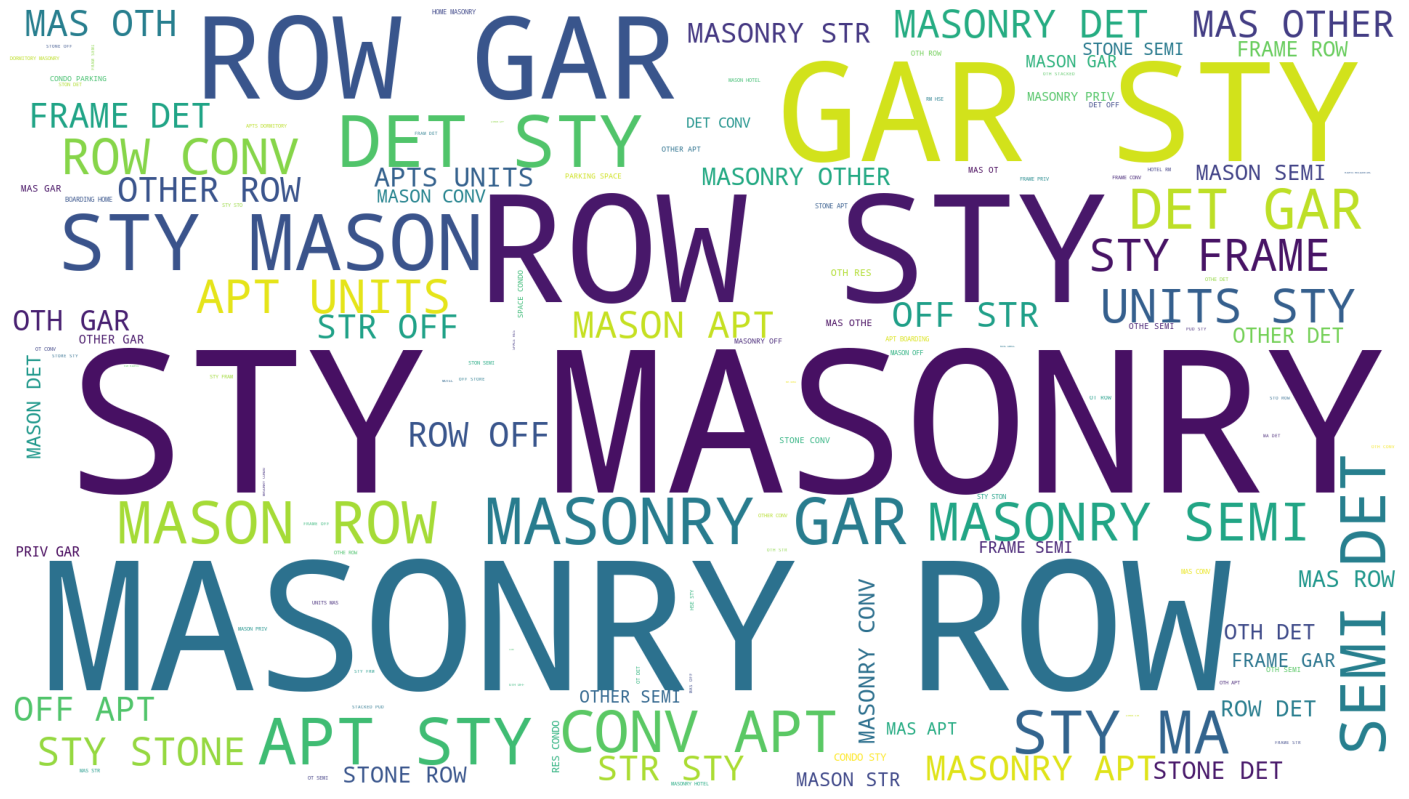

In [194]:
# House description wordcount
plt.subplots(figsize = (25, 15))
wordcloud=WordCloud(background_color = 'white', 
                    width = 1920, 
                    height = 1080
                    ).generate(" ".join(phi_pp_df_2.building_code_description))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# The result show that most house/ building type belong to story mansory
# STY: Story, GAR: Gargage, 

#### Next, we go to see the correlation of other features, such as basement, type_heater, central_air,fuel and more

In [121]:
# Clean some un-make sense features that might affect for the house value prediction
# Drop 'depth' column that depth = 0
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.depth == 0].index)

In [122]:
phi_pp_df_2.shape

(477799, 44)

In [123]:
phi_pp_df_2.head()

,index,lng,building_code_description,category_code,category_code_description,central_air,depth,exempt_building,exempt_land,exterior_condition,...,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,zip_code,lat,number_of_bedrooms
6,6,-75.147208,ROW 3 STY MASONRY,1,Single Family,Y,40.0,0.0,0.0,3.0,...,1131.0,A,None,None,None,I,1920,19147,39.930328,4.0
7,7,-75.147254,ROW 3 STY MASONRY,1,Single Family,Y,40.0,45000.0,0.0,3.0,...,1235.0,H,None,None,None,I,1920,19147,39.930338,3.0
8,8,-75.147302,ROW 2 STY MASONRY,1,Single Family,N,40.0,125300.0,0.0,4.0,...,816.0,A,None,None,None,I,1920,19147,39.930343,1.0
9,9,-75.147349,ROW 2 STY MASONRY,1,Single Family,N,38.0,0.0,0.0,4.0,...,792.0,H,None,None,None,I,1920,19147,39.930346,2.0
10,10,-75.147396,ROW 2 STY MASONRY,1,Single Family,N,40.0,0.0,0.0,4.0,...,816.0,H,None,None,None,I,1920,19147,39.930352,2.0


In [124]:
# drop the index column since not relative to market_value
phi_pp_df_2 = phi_pp_df_2.drop(['index'], axis = 1)

In [195]:
phi_pp_df_2.shape

(477799, 43)

In [196]:
corr_phi_pp_df_2 = phi_pp_df_2.corr()

In [197]:
#Let's look at the correlation 
corr_phi_pp_df_2.sort_values(['market_value'], ascending = False, inplace = True)
print('Feature correlation relative to the market_value:')
print(corr_phi_pp_df_2.market_value)

Feature correlation relative to the market_value:
market_value           1.000000
taxable_land           0.918331
taxable_building       0.824931
exempt_building        0.488443
sale_price             0.341099
total_area             0.315572
total_livable_area     0.297999
fireplaces             0.239544
number_stories         0.184362
category_code          0.181444
off_street_open        0.166651
exempt_land            0.157630
garage_spaces          0.103951
number_of_bathrooms    0.037542
depth                  0.033296
lng                    0.017867
street_code            0.009998
frontage               0.000153
homestead_exemption   -0.006597
lat                   -0.053107
quality_grade         -0.078941
number_of_bedrooms    -0.116584
geographic_ward       -0.128331
number_of_rooms       -0.179538
exterior_condition    -0.341322
interior_condition    -0.341657
Name: market_value, dtype: float64


#### Now, we can see that, the top 5 relative features with market_value are : 
#### 1. taxable_land, 2. taxable_buliding, 3. exempt_building, 4. sale_price, 5. total_area

In [198]:
# #Here, we drop those negative value features before we make a heatmap for data visualization
# phi_pp_df_2_for_corr_vis = phi_pp_df_2.drop(columns=['homestead_exemption', 'lat', 'quality_grade','number_of_bedrooms',
#                         'geographic_ward','number_of_rooms','exterior_condition', 'interior_condition'])

In [199]:
phi_pp_df_2_for_corr_vis = phi_pp_df_2_for_corr_vis.corr()

Text(0.5, 1.0, 'Heatmap of features with market_vaule')

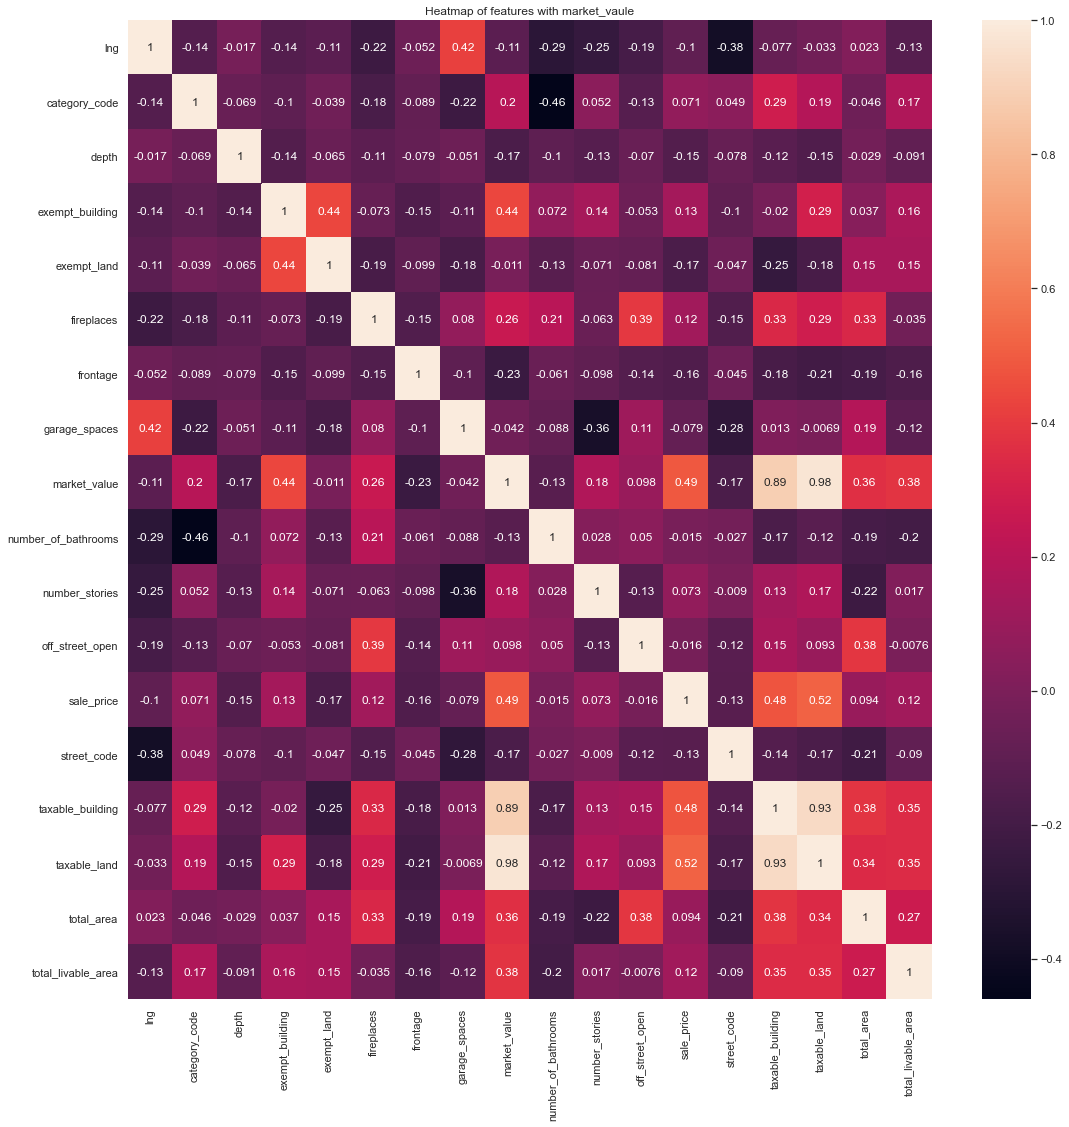

In [200]:
#Let's visualize this correlation
sns.set(font_scale =1)
corr_vis = phi_pp_df_2_for_corr_vis
cols = corr_vis.nlargest(18, 'market_value')['market_value'].index
# phi_pp_df_2_for_corr_vis=np.corrcoef(phi_pp_df_2_for_corr_vis[cols].values.T)
plt.figure(figsize =(18, 18))
ax = sns.heatmap(phi_pp_df_2_for_corr_vis, annot=True)
ax.set_title("Heatmap of features with market_vaule")

### Machine Learning -- Linear Regression